In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-beans-saad/Coffee Bean.csv
/kaggle/input/coffee-beans-saad/test/Dark/dark (2).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (95).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (45).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (8).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (83).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (15).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (98).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (91).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (22).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (23).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (75).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (55).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (11).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (39).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (100).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (33).png
/kaggle/input/coffee-beans-saad/test/Dark/dark (79).png
/

In [18]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torchvision import models, transforms

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier


In [19]:
base_dir = "/kaggle/input/coffee-beans-saad"

def create_dataframe(data_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)
    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    return df.sample(frac=1).reset_index(drop=True)

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

print("Train size:", len(train_df))
print("Test size:", len(test_df))
train_df.head()


Train size: 1200
Test size: 400


,file_path,label
0,/kaggle/input/coffee-beans-saad/train/Light/li...,Light
1,/kaggle/input/coffee-beans-saad/train/Medium/m...,Medium
2,/kaggle/input/coffee-beans-saad/train/Light/li...,Light
3,/kaggle/input/coffee-beans-saad/train/Green/gr...,Green
4,/kaggle/input/coffee-beans-saad/train/Dark/dar...,Dark


In [20]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = models.resnet50(pretrained=True)
cnn_model.fc = nn.Identity()  # remove final classification layer
cnn_model.to(device)
cnn_model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
def extract_features(df, transform_type):
    features, labels = [], []
    for _, row in df.iterrows():
        image = Image.open(row["file_path"]).convert("RGB")
        image = transform_type(image).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = cnn_model(image).cpu().numpy().flatten()
        features.append(feat)
        labels.append(row["label"])
    return np.array(features), np.array(labels)

print("Extracting training features...")
X_train, y_train = extract_features(train_df, train_transform)
print("Extracting test features...")
X_test, y_test = extract_features(test_df, test_transform)

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)


Extracting training features...
Extracting test features...
Train features shape: (1200, 2048)
Test features shape: (400, 2048)


In [23]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
class_names = le.classes_
print("Classes:", class_names)


Classes: ['Dark' 'Green' 'Light' 'Medium']


In [24]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_metrics_knn = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train_enc), 1):
    print(f"\n===== Fold {fold} =====")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train_enc[train_idx], y_train_enc[val_idx]
    
    start_time = time.time()
    knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_model.fit(X_tr, y_tr)
    train_time = time.time() - start_time
    
    # Evaluate on validation set
    y_val_pred = knn_model.predict(X_val)
    y_val_prob = knn_model.predict_proba(X_val)
    
    accuracy = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(label_binarize(y_val, classes=range(len(class_names))), y_val_prob, multi_class="ovr")
    
    print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, Training Time: {train_time:.2f} sec")
    fold_metrics_knn.append({"fold": fold, "accuracy": accuracy, "auc": auc, "train_time": train_time})

# Average metrics across folds
avg_accuracy_knn = np.mean([m["accuracy"] for m in fold_metrics_knn])
avg_auc_knn = np.mean([m["auc"] for m in fold_metrics_knn])
avg_time_knn = np.mean([m["train_time"] for m in fold_metrics_knn])

print(f"\n===== Average Metrics Across 5 Folds (k-NN) =====")
print(f"Accuracy: {avg_accuracy_knn:.4f}, AUC: {avg_auc_knn:.4f}, Avg Training Time: {avg_time_knn:.2f} sec")



===== Fold 1 =====
Accuracy: 0.8667, AUC: 0.9723, Training Time: 0.00 sec

===== Fold 2 =====
Accuracy: 0.8708, AUC: 0.9743, Training Time: 0.00 sec

===== Fold 3 =====
Accuracy: 0.8958, AUC: 0.9677, Training Time: 0.00 sec

===== Fold 4 =====
Accuracy: 0.8417, AUC: 0.9610, Training Time: 0.00 sec

===== Fold 5 =====
Accuracy: 0.8625, AUC: 0.9702, Training Time: 0.00 sec

===== Average Metrics Across 5 Folds (k-NN) =====
Accuracy: 0.8675, AUC: 0.9691, Avg Training Time: 0.00 sec


In [25]:
knn_model_final = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model_final.fit(X_train, y_train_enc)


KNeighborsClassifier(n_jobs=-1)


Test Accuracy (k-NN): 0.8925
              precision    recall  f1-score   support

        Dark       0.88      0.90      0.89       100
       Green       0.96      0.96      0.96       100
       Light       0.93      0.87      0.90       100
      Medium       0.81      0.84      0.82       100

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



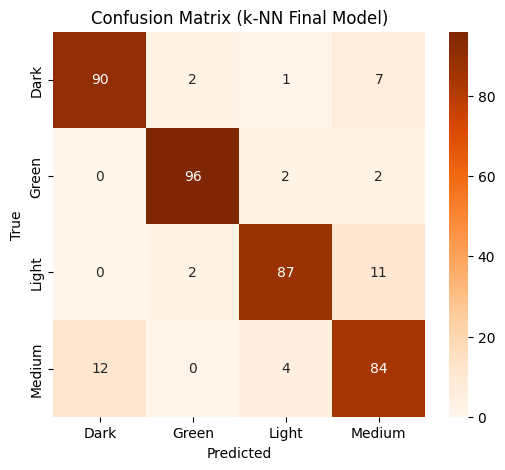

Test AUC (k-NN): 0.9800


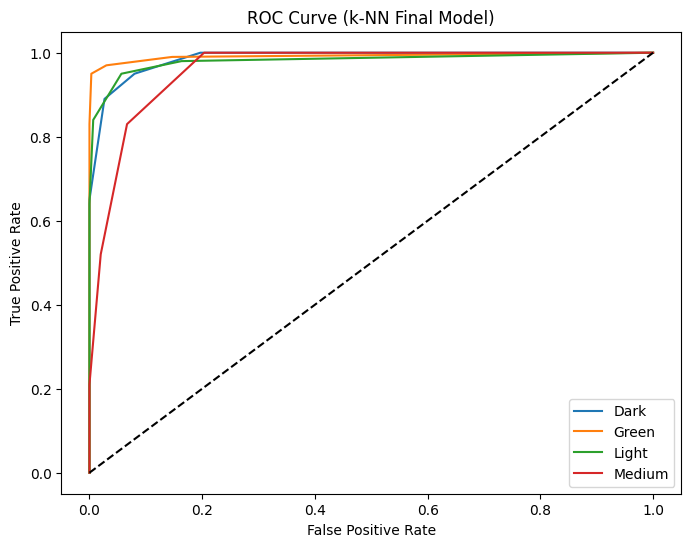

In [26]:
y_pred_knn = knn_model_final.predict(X_test)
y_prob_knn = knn_model_final.predict_proba(X_test)

accuracy_knn = accuracy_score(y_test_enc, y_pred_knn)
print(f"\nTest Accuracy (k-NN): {accuracy_knn:.4f}")
print(classification_report(y_test_enc, y_pred_knn, target_names=class_names))

# Confusion Matrix
cm_knn = confusion_matrix(y_test_enc, y_pred_knn)
plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (k-NN Final Model)")
plt.show()

# ROC & AUC
y_test_bin = label_binarize(y_test_enc, classes=range(len(class_names)))
auc_knn = roc_auc_score(y_test_bin, y_prob_knn, multi_class="ovr")
print(f"Test AUC (k-NN): {auc_knn:.4f}")

# ROC Curve
plt.figure(figsize=(8,6))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_knn[:, i])
    plt.plot(fpr, tpr, label=f"{class_name}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (k-NN Final Model)")
plt.legend()
plt.show()
